# Diffusion maps using NumPy backend

In [1]:
%load_ext nb_mypy
%nb_mypy Off
%matplotlib ipympl

Version 1.0.5


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
from ipywidgets import interact, IntSlider
from nlsa.abstract_algebra2 import ldivide_by
from nlsa.function_algebra2 import compose
from nlsa.kernels import dmsym_normalize, make_exponential_rbf,\
    make_integral_operator
from nlsa.numpy.vector_algebra import MeasureFnAlgebra, ScalarField,\
        VectorAlgebra, counting_measure, eval_at, sqeuclidean
from numpy.typing import NDArray
from scipy.sparse.linalg import LinearOperator, eigs
from typing import Callable, Literal, TypeVar

In [3]:
S = TypeVar('S')
T = TypeVar('T')
F = Callable[[S], T]

## Eigendecomposition

In [6]:
R = np.float64
N = Literal[64]
Rn = NDArray[R]
X = NDArray[R]
Xs = NDArray[R]
Y = NDArray[R]

n: N = 2**6
n_eig = 9
alpha = '1'
dtype = np.float64
thetas = np.linspace(0, 2*np.pi, n)
xs: Xs = np.column_stack((np.cos(thetas), np.sin(thetas)))

r_n: VectorAlgebra[N, R] = VectorAlgebra(dim=n, dtype=dtype)
ell2: MeasureFnAlgebra[X, N, R] =\
    MeasureFnAlgebra(dim=n,
                     dtype=dtype,
                     inclusion_map=eval_at(xs),
                     measure=counting_measure)
rbf = make_exponential_rbf(ScalarField(dtype=dtype),
                           bandwidth=dtype(0.05))
k: Callable[[X, X], Y] = compose(rbf, sqeuclidean)
p: Callable[[X, X], Y] = dmsym_normalize(ell2, alpha, k)
p_op: Callable[[Rn], F[X, Y]] = make_integral_operator(ell2, p)
g_op: Callable[[Rn], Rn] = compose(ell2.incl, p_op)
a = LinearOperator(shape=(n, n), dtype=dtype, matvec=g_op)

In [9]:
%%timeit -n1 -r1 
print(f'n = {n}')
print(f'n_eig = {n_eig}')

start_time = time.perf_counter()
[unsorted_evals, unsorted_evecs] = eigs(a, n_eig, which='LM')
end_time = time.perf_counter()
print(f'Eigendecomposition took {end_time - start_time:.3E} s')

start_time = time.perf_counter()
isort = np.argsort(np.real(unsorted_evals))
evals = np.real(unsorted_evals[isort[::-1]])
laplacian_evals = (1/evals - 1) / (1/evals[1] - 1)
symmetric_evecs = np.real(unsorted_evecs[:, isort[::-1]])
from_sym = ldivide_by(r_n, symmetric_evecs[:, 0])
markov_evecs = from_sym(symmetric_evecs)
end_time = time.perf_counter()
print(f'Markov normalization took {end_time - start_time:.3E} s')

n = 64
n_eig = 9
Eigendecomposition took 3.513E-02 s
Markov normalization took 5.104E-05 s
35.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


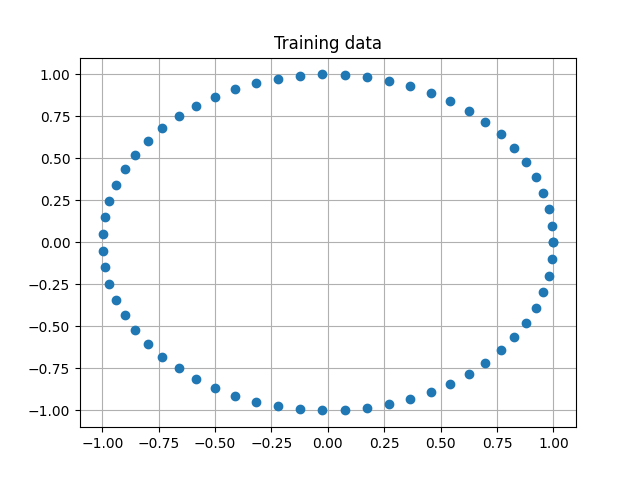

In [59]:
i_fig = 1

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
ax.cla()
ax.plot(xs[:, 0], xs[:, 1], 'o')
ax.grid()
ax.set_title('Training data');

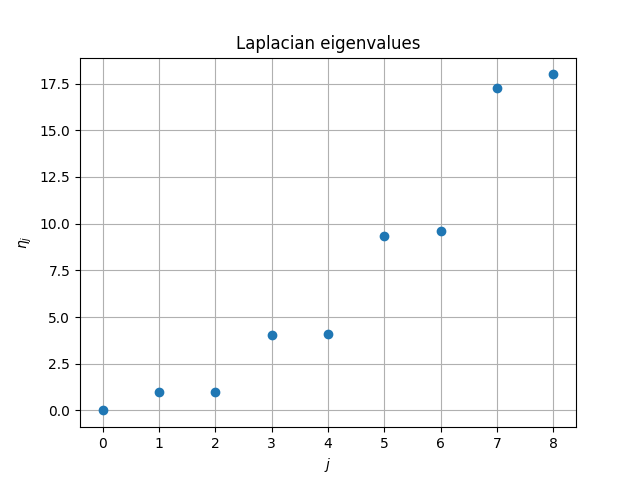

In [60]:
i_fig = 2
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax.cla()
ax.plot(np.arange(0, n_eig), laplacian_evals, 'o')
ax.grid()
ax.set_xlabel('$j$')
ax.set_ylabel('$\\eta_j$')
ax.set_title('Laplacian eigenvalues');

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=4), Output()), _dom_cla…

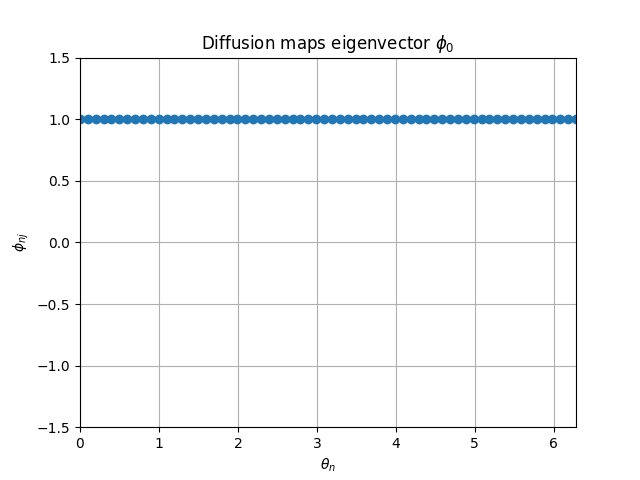

In [26]:
i_fig = 3

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
j_slider = IntSlider(value=0, min=0, max=n_eig - 1, continuous_update=False)

@interact(j=j_slider)
def plot_phi(j):
    ax.cla()
    ax.plot(thetas, markov_evecs[:, j], 'o')
    ax.grid()
    ax.set_xlabel('$\\theta_n$')
    ax.set_ylabel('$\\phi_{nj}$')
    ax.set_title(f'Diffusion maps eigenvector $\\phi_{{{j}}}$') 
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-1.5, 1.5)

## Nystrom extension

We perfom Nystrom extension to compute functions that interpolate the kernel eigenvectors. For that, we build the integral operator `p_op` associated with the diffusion maps kernel function `p` without symmetrization. We return the interpolated eigenfunctions as a list of functions `varphi`. We plot these functions on a uniform grid on the circle.

In [72]:
p = rkhs.dm_normalize(vec, alpha, unit, incl, mu, k)
incl = partial(fun.evaluate_at, xs)
p_op = rkhs.kernel_operator(vep, incl, mu, p)
nyst = rkhs.nystrom_basis(vec, p_op, lamb, phi.T)
synth = synthesis_operator(fun, nyst)
u = partial(vec.std_basis, n_eig, shape2d = 'col')
varphi = [synth(u(j)) for j in range(0, n_eig)]

In [73]:
n_grd = 400

theta_grd = np.linspace(0, 2 * np.pi, n_grd)
x_grd = dyn.circle_embedding_r2(theta_grd)

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=10), Output()), _dom_cl…

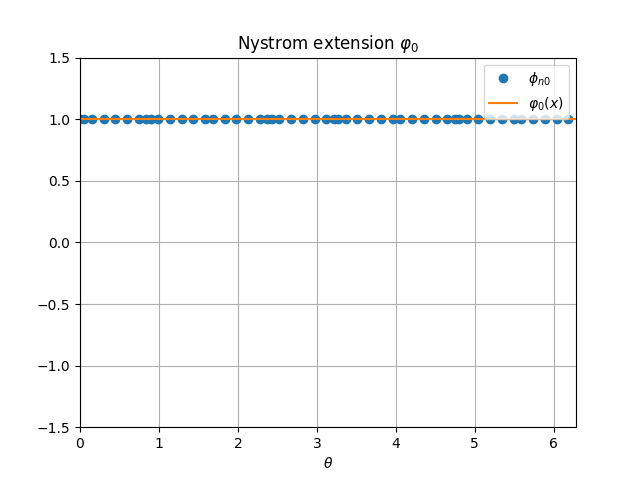

In [74]:
i_fig = 4

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
j_slider = IntSlider(value=0, min=0, max=n_eig - 1, continuous_update=False)

@interact(j=j_slider)
def plot_varphi(j):
    ax.cla()
    ax.plot(thetas, phi[:, j], 'o', label=f'$\\phi_{{n{j}}}$')
    ax.plot(theta_grd, varphi[j](x_grd), '-', label=f'$\\varphi_{{{j}}}(x)$') 
    ax.grid()
    ax.legend()
    ax.set_xlabel('$\\theta$')
    ax.set_title(f'Nystrom extension $\\varphi_{{{j}}}$') 
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-1.5, 1.5)

## Regression in the diffusion maps basis

We perform supervised learning (regression) of the standard embedding map $f: S^1 \to \mathbb R^2$ of the circle into the plane, $f(\theta) = (\cos(\theta),\sin(\theta))$. Given the falues $f(\theta_n)$ of $f$ on the training data (stored in array `xs`) we compute expansion coefficients `c` with respect to the Nystrom basis that reconstruct $f$ as a function `f_rec`. We test the accuracy of `f_rec` on a regular grid of points on the circle. 

In [75]:
w_inner = make_l2_innerp(vep, riesz_dual(vec.innerp, w))
c = w_inner(phi.T, xs.T)
f_rec = synth(c)
x_pred = f_rec(x_grd)

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=1), Output()), _dom_cla…

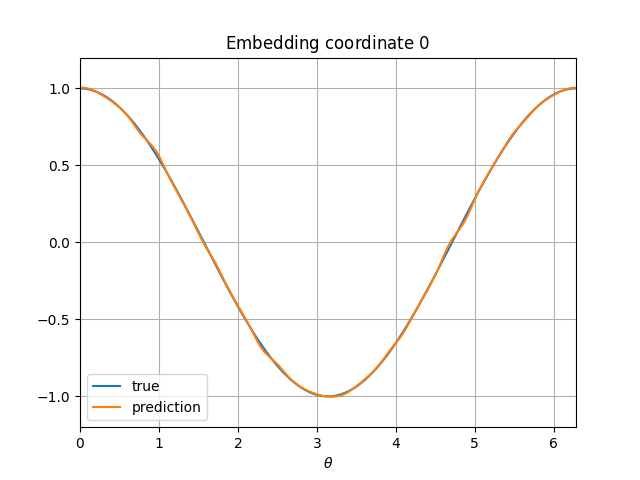

In [76]:
i_fig = 5

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
j_slider = IntSlider(value=0, min=0, max=1, continuous_update=False)

@interact(j=j_slider)
def plot_pred(j):
    ax.cla()
    ax.plot(theta_grd, x_grd[:, j], '-', label='true')
    ax.plot(theta_grd, x_pred[:, j], '-', label='prediction') 
    ax.grid()
    ax.legend()
    ax.set_xlabel('$\\theta$')
    ax.set_title(f'Embedding coordinate ${j}$') 
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-1.2, 1.2)